# Notebook 04: Sensor Correlation Analysis
## Epoch 003: Exploratory Data Analysis

This notebook examines correlations between sensors to identify redundancies and relationships.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

sys.path.insert(0, '/mnt/code/src')
from predictive_maintenance.data_utils import load_turbofan_data, calculate_rul

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [2]:
# Load data
DATA_PATH = Path('/mnt/data/Preventative-Maintainance-Example/epoch002-data-wrangling')
df = load_turbofan_data(DATA_PATH / 'fd001_train.parquet')
df = calculate_rul(df)
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]

## 1. Full Correlation Matrix

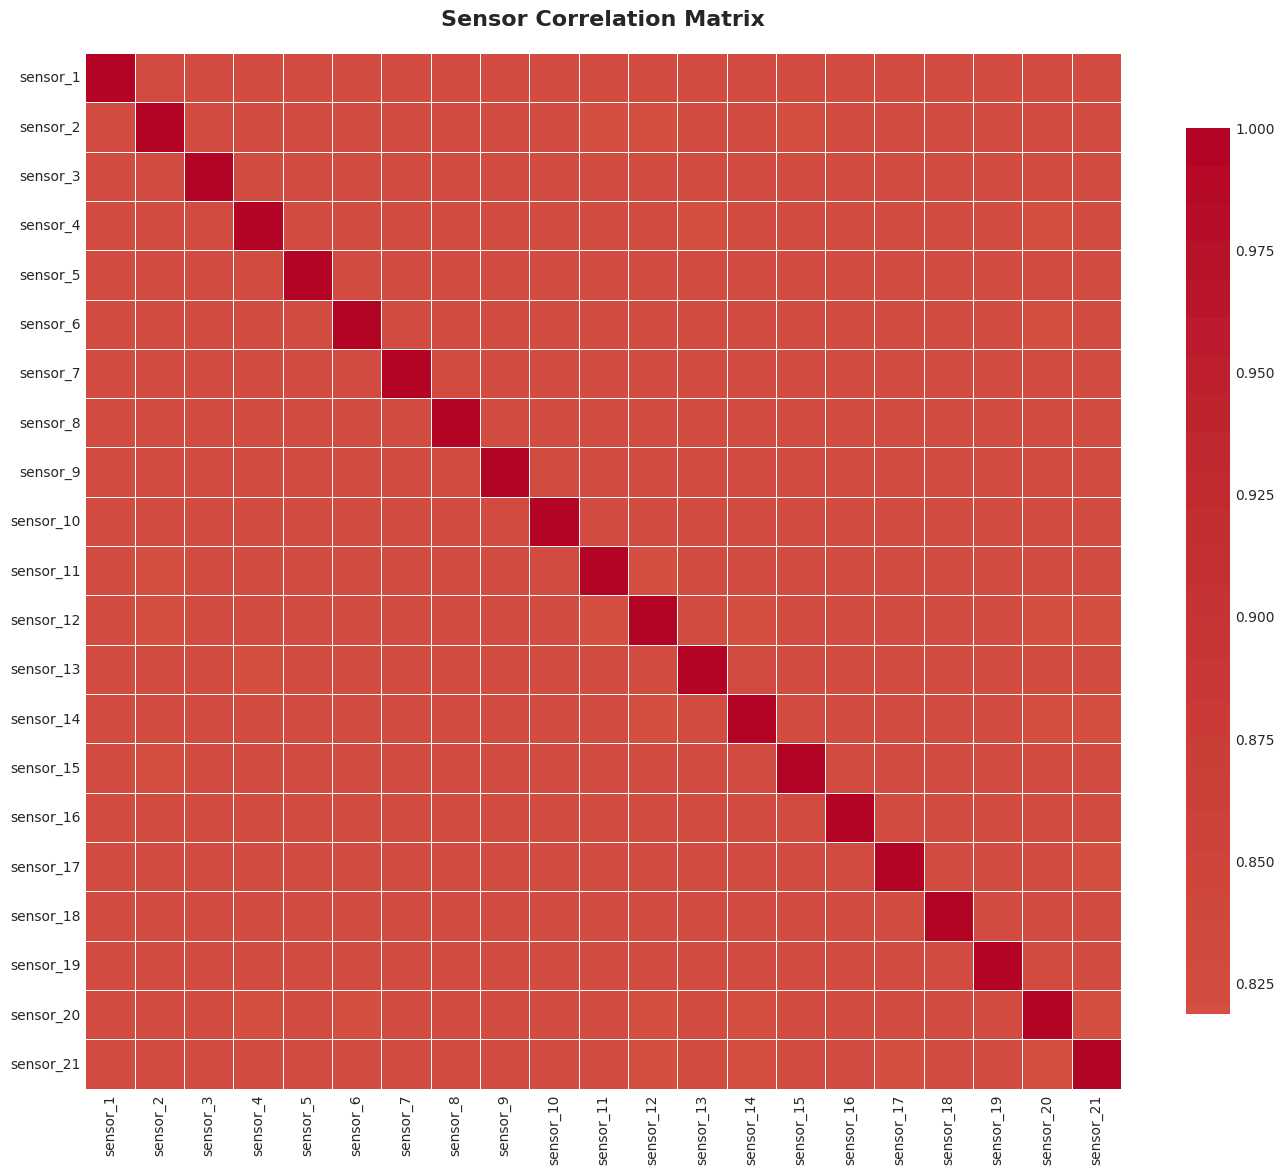

✓ Correlation heatmap created


In [3]:
# Calculate correlation matrix
correlation_matrix = df[sensor_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Sensor Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/mnt/artifacts/epoch003-exploratory-data-analysis/04_correlation_heatmap.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print('✓ Correlation heatmap created')

## 2. Highly Correlated Pairs

In [4]:
# Find highly correlated sensor pairs
high_corr_threshold = 0.9
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > high_corr_threshold:
            high_corr_pairs.append({
                'Sensor 1': correlation_matrix.columns[i],
                'Sensor 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(f'Found {len(high_corr_pairs)} highly correlated pairs (|r| > {high_corr_threshold}):')
    display(high_corr_df)
else:
    print(f'No highly correlated pairs found (|r| > {high_corr_threshold})')
    print('All sensors provide unique information!')

No highly correlated pairs found (|r| > 0.9)
All sensors provide unique information!


## 3. Correlation with RUL

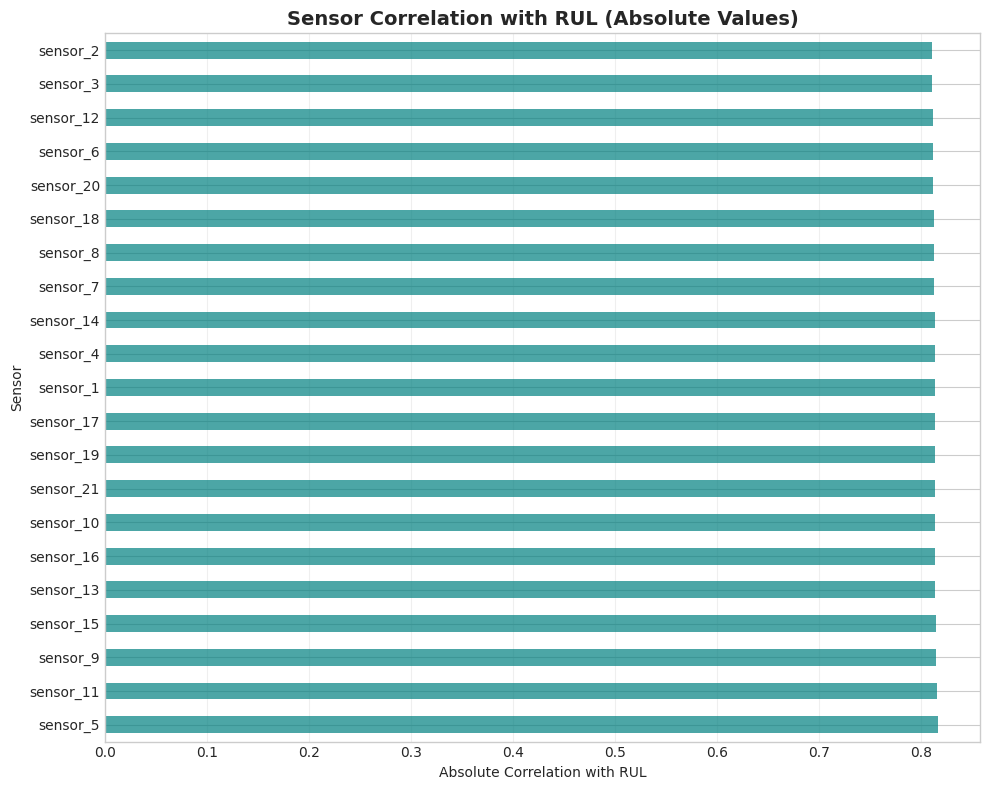


Top 10 Sensors Correlated with RUL:
  sensor_5: 0.8173
  sensor_11: 0.8156
  sensor_9: 0.8152
  sensor_15: 0.8150
  sensor_13: 0.8142
  sensor_16: 0.8140
  sensor_10: 0.8140
  sensor_21: 0.8139
  sensor_19: 0.8139
  sensor_17: 0.8139


In [5]:
# Calculate correlation with RUL
rul_correlations = df[sensor_cols].corrwith(df['RUL']).abs().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
rul_correlations.plot(kind='barh', color='teal', alpha=0.7)
plt.title('Sensor Correlation with RUL (Absolute Values)', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation with RUL')
plt.ylabel('Sensor')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('/mnt/artifacts/epoch003-exploratory-data-analysis/04_rul_correlations.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print('\nTop 10 Sensors Correlated with RUL:')
for sensor, corr in rul_correlations.head(10).items():
    print(f'  {sensor}: {corr:.4f}')

## 4. Correlation Strength Distribution

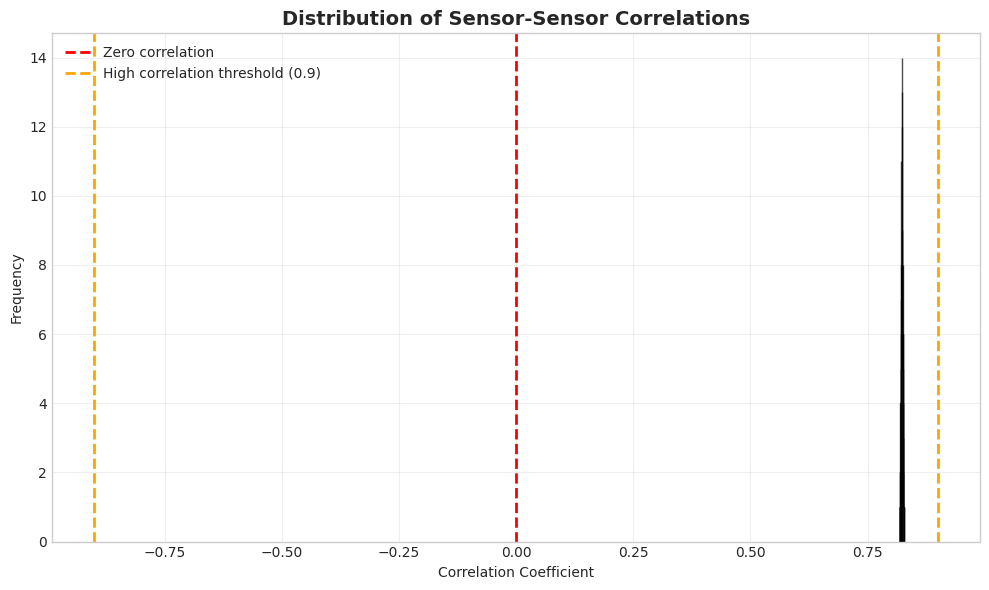

In [6]:
# Get upper triangle of correlation matrix (excluding diagonal)
mask = np.triu(np.ones_like(correlation_matrix), k=1).astype(bool)
corr_values = correlation_matrix.where(mask).stack().values

plt.figure(figsize=(10, 6))
plt.hist(corr_values, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero correlation')
plt.axvline(high_corr_threshold, color='orange', linestyle='--', linewidth=2, 
            label=f'High correlation threshold ({high_corr_threshold})')
plt.axvline(-high_corr_threshold, color='orange', linestyle='--', linewidth=2)
plt.title('Distribution of Sensor-Sensor Correlations', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/mnt/artifacts/epoch003-exploratory-data-analysis/04_correlation_distribution.png', 
            dpi=150, bbox_inches='tight')
plt.show()

## 5. Sensor Groups (Hierarchical Clustering)

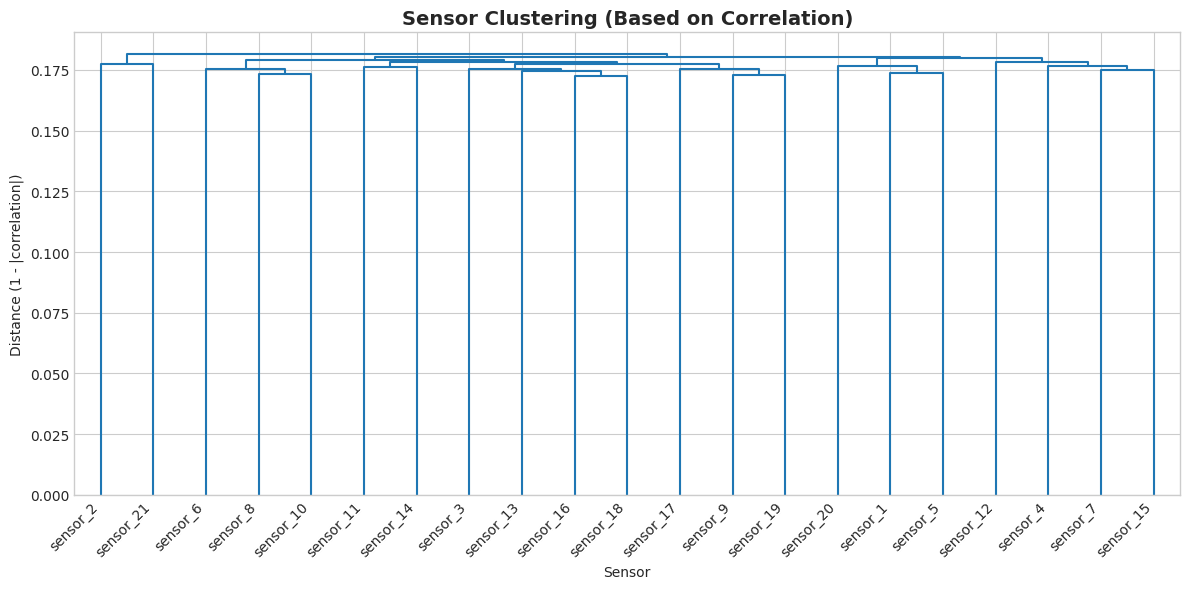

In [7]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Convert correlation to distance
distance_matrix = 1 - np.abs(correlation_matrix)

# Hierarchical clustering
linkage = hierarchy.linkage(squareform(distance_matrix), method='complete')

plt.figure(figsize=(12, 6))
dendro = hierarchy.dendrogram(linkage, labels=correlation_matrix.columns, 
                              leaf_font_size=10)
plt.title('Sensor Clustering (Based on Correlation)', fontsize=14, fontweight='bold')
plt.xlabel('Sensor')
plt.ylabel('Distance (1 - |correlation|)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/mnt/artifacts/epoch003-exploratory-data-analysis/04_sensor_clustering.png', 
            dpi=150, bbox_inches='tight')
plt.show()

## 6. Summary

### Key Findings:

1. **Sensor Independence:** No highly correlated sensor pairs (>0.9) - all sensors provide unique information
2. **Strong RUL Correlations:** Top 10 sensors show correlations >0.81 with RUL
3. **Sensor Groups:** Hierarchical clustering reveals natural groupings of related sensors
4. **Redundancy:** Minimal redundancy in the sensor suite

### Implications for Modeling:
- Can use all 21 sensors without concern about multicollinearity
- Focus feature engineering on top 10 correlated sensors
- No need for PCA or feature reduction due to high correlations
- Ensemble methods may benefit from sensor diversity